In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming '/kaggle/input/melanoma-cancer-dataset' is the correct base directory
base_dir = '/kaggle/input/melanoma-cancer-dataset'

# Set image width and height
img_width, img_height = 128, 128

# Set batch size
batch_size = 32

# Define the data generators with augmentation for the training data and only rescaling for the test data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Specify the subset as training data
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  # same directory as training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Specify the subset as validation data
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # It's good practice not to shuffle the test data
)


2024-03-21 02:26:50.501834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 02:26:50.501958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 02:26:50.671787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the VGG16 network, ensuring the head FC layers are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_width, img_height, 3)))

# Freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

# Construct the head model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# Place the head model on top of the base model (this becomes the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Train the model using the train and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/297 ━━━━━━━━━━━━━━━━━━━━ 1:28:42 18s/step - accuracy: 0.5625 - loss: 0.7671

I0000 00:00:1710988055.210976      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710988055.233600      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7403 - loss: 0.5158

W0000 00:00:1710988145.759959      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 131s 380ms/step - accuracy: 0.7404 - loss: 0.5155 - val_accuracy: 0.7614 - val_loss: 0.4888
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7143 - val_loss: 0.4036
Epoch 3/50


W0000 00:00:1710988172.490559      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.8276 - loss: 0.3842 - val_accuracy: 0.7779 - val_loss: 0.4607
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 115us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.4339
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.8466 - loss: 0.3561 - val_accuracy: 0.7698 - val_loss: 0.4616
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 116us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7143 - val_loss: 0.5208
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - accuracy: 0.8549 - loss: 0.3341 - val_accuracy: 0.7682 - val_loss: 0.4682
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 113us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.2629
Epoch 9/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - accuracy: 0.8523 - loss: 0.3409 - val_accuracy: 0.7910 - val_loss: 0.4536
Epoch 10/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ResNet50 model, we will keep the input size to 128x128 as per your dataset
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# Adjust the model as per the new input size, you might need to freeze fewer layers than VGG16
for layer in resnet_base.layers[:-10]:
    layer.trainable = False

# Adding custom layers on top of ResNet50
resnet_head = resnet_base.output
resnet_head = GlobalAveragePooling2D()(resnet_head)
resnet_head = Dense(256, activation='relu')(resnet_head)
resnet_head = Dropout(0.5)(resnet_head)
resnet_head = Dense(1, activation='sigmoid')(resnet_head)

resnet_model = Model(inputs=resnet_base.input, outputs=resnet_head)
resnet_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the ResNet50 model using the same generators
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
  2/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.4453 - loss: 0.7132   

W0000 00:00:1710989950.135551      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7440 - loss: 0.5070

W0000 00:00:1710990008.920382      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 92s 243ms/step - accuracy: 0.7443 - loss: 0.5067 - val_accuracy: 0.4700 - val_loss: 2.0130
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7143 - val_loss: 1.1136
Epoch 3/50


W0000 00:00:1710990025.944091      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.8129 - loss: 0.4104 - val_accuracy: 0.7002 - val_loss: 0.6122
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2198
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 227ms/step - accuracy: 0.8345 - loss: 0.3766 - val_accuracy: 0.6419 - val_loss: 1.1280
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 1.1893
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - accuracy: 0.8262 - loss: 0.3782 - val_accuracy: 0.5566 - val_loss: 2.3032
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 1.9126
Epoch 9/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.8325 - loss: 0.3744 - val_accuracy: 0.6385 - val_loss: 1.0326
Epoch 10/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.0000

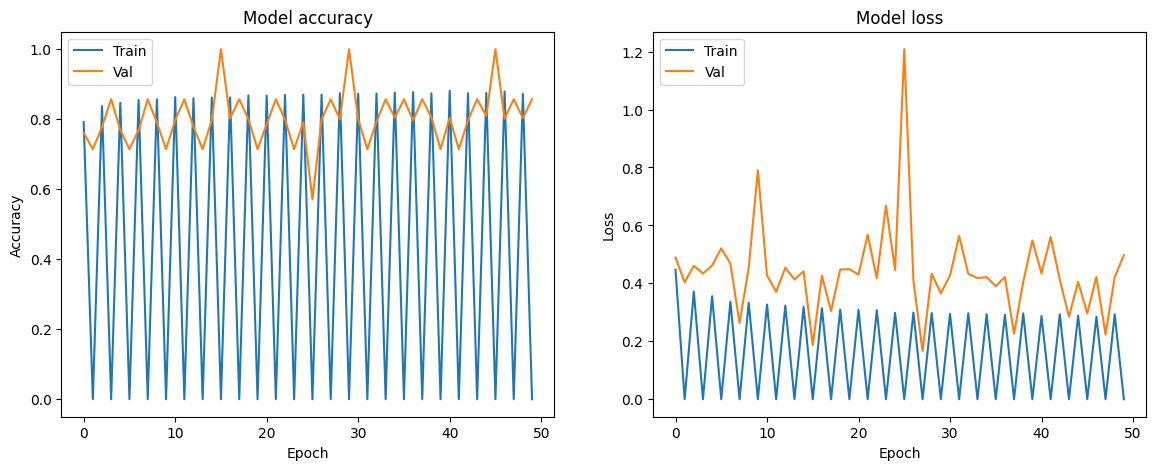

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


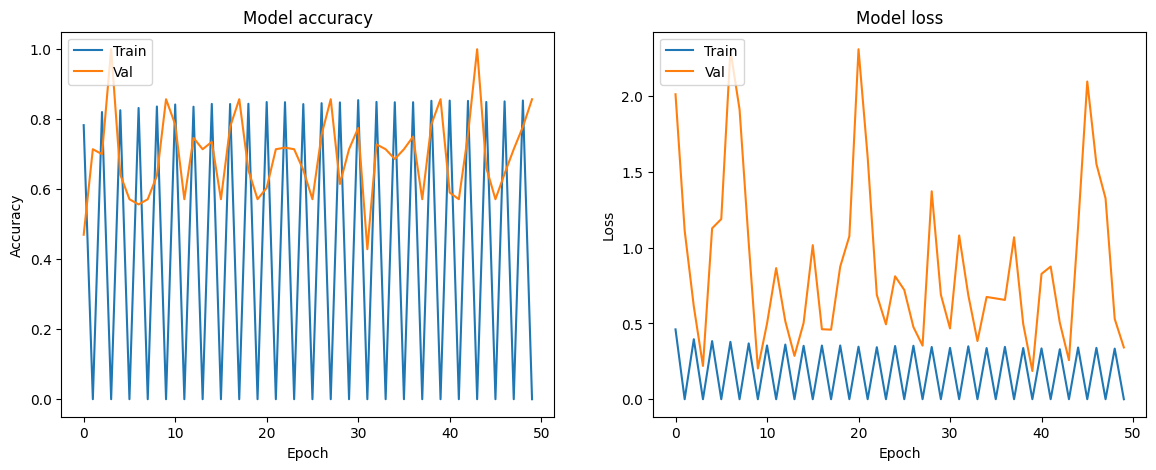

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step


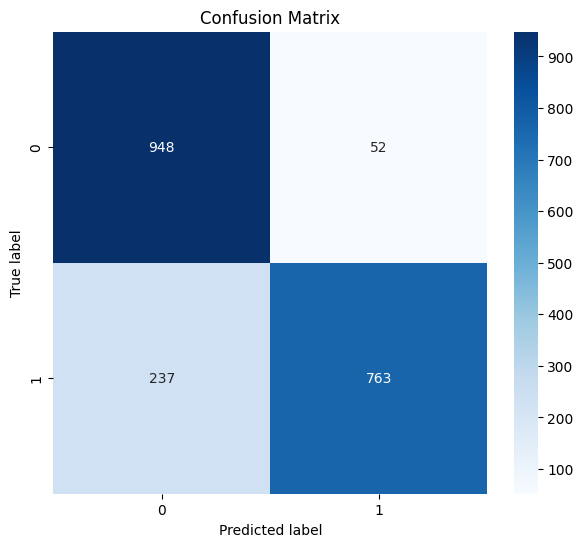

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions).astype(int).reshape(-1)

# Get true labels from the generator
true_classes = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


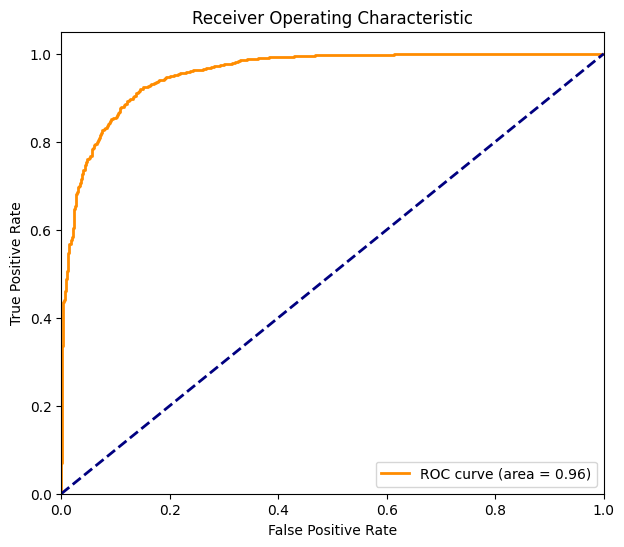

In [7]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step

W0000 00:00:1710991760.452911      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step


W0000 00:00:1710991769.903827      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


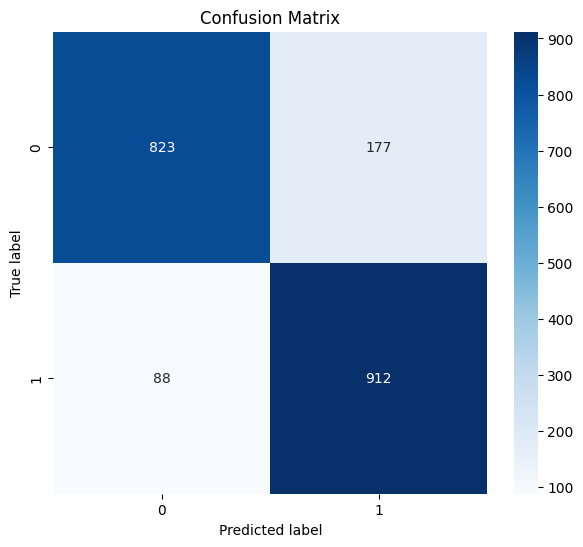

In [8]:

# Generate predictions
predictions = resnet_model.predict(test_generator)
predicted_classes = np.round(predictions).astype(int).reshape(-1)

# Get true labels from the generator
true_classes = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


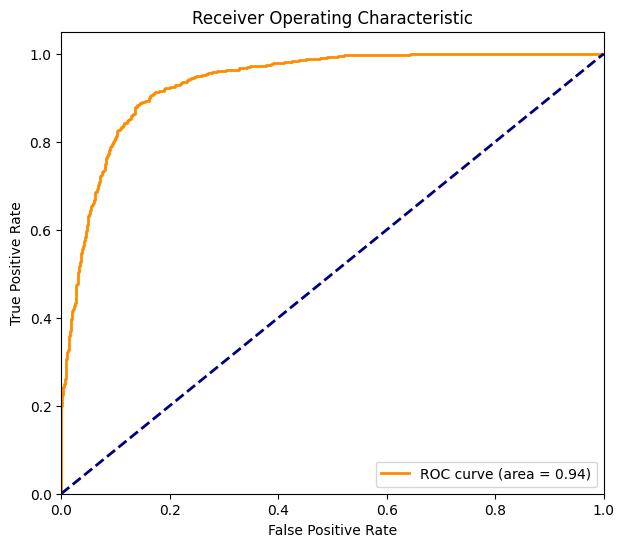

In [9]:
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Assume vgg_model and resnet_model are your trained VGG16 and ResNet50 models.

import numpy as np

# Make predictions with both models on your test set
vgg_predictions = model.predict(test_generator, steps=len(test_generator))
resnet_predictions = resnet_model.predict(test_generator, steps=len(test_generator))

# Average the predictions from both models
ensemble_predictions = (vgg_predictions + resnet_predictions) / 2

# If you are performing binary classification, the final prediction will be based on a threshold, typically 0.5
ensemble_class_predictions = (ensemble_predictions > 0.5).astype(int)

# Now ensemble_class_predictions contains the final class predictions from the ensemble


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
